# 🧠 From N-grams to GPT: Building LLMs from Scratch

---

> **Goal:** Build every piece of an LLM from scratch — from counting words to a working GPT that generates Shakespeare!

## 📚 Journey Map

| Part | Concept
|------|---------|
| **Part 1** | N-gram Language Models |
| **Part 2** | Tokenization & Embeddings |
| **Part 3** | Single-Head Self-Attention |
| **Part 4** | Multi-Head Attention |
| **Part 5** | Feed-Forward + Transformer Block |
| **Part 6** | Full GPT Model Assembly |
| **Part 7** | Training Loop & Text Generation |


⚡ **First:** Go to `Runtime → Change runtime type → T4 GPU`

Setup & Imports (Code)

In [ ]:
import torch
import torch.nn as nn
from torch.nn import functional as F
import requests
import random
import math
import matplotlib.pyplot as plt
import matplotlib.patches as mpatches
import numpy as np
from collections import defaultdict, Counter
import warnings
warnings.filterwarnings('ignore')

# ── Device Check ──────────────────────────────────────────────
device = 'cuda' if torch.cuda.is_available() else 'cpu'
print(f"🖥️  Device : {device}")
if device == 'cuda':
    print(f"   GPU    : {torch.cuda.get_device_name(0)}")
else:
    print("     No GPU! Go to Runtime → Change runtime type → T4 GPU")

torch.manual_seed(42)
print("\n All imports successful!")

🖥️  Device : cuda
   GPU    : Tesla T4

 All imports successful!


Load Dataset (Code)

In [ ]:
# ══════════════════════════════════════════════════════════════
# DATASET — Tiny Shakespeare (~1M characters)
# ══════════════════════════════════════════════════════════════

url  = "https://raw.githubusercontent.com/karpathy/char-rnn/master/data/tinyshakespeare/input.txt"
text = requests.get(url).text

print(f"📜 Loaded {len(text):,} characters  |  {len(text.split()):,} words")
print(f"\n--- First 400 chars ---")
print(text[:400])
print("..." )

📜 Loaded 1,115,394 characters  |  202,651 words

--- First 400 chars ---
First Citizen:
Before we proceed any further, hear me speak.

All:
Speak, speak.

First Citizen:
You are all resolved rather to die than to famish?

All:
Resolved. resolved.

First Citizen:
First, you know Caius Marcius is chief enemy to the people.

All:
We know't, we know't.

First Citizen:
Let us kill him, and we'll have corn at our own price.
Is't a verdict?

All:
No more talking on't; let it 
...


---
# 🔢 PART 1 — N-gram Language Models
### *"Predict the next word by counting what came before"*

**Theory (from slides):**
- An **N-gram** is a sequence of N consecutive tokens
- A **Bigram** model predicts the next word given the previous 1 word
- A **Trigram** model uses the previous 2 words
- All predictions = **counted frequencies** in training data

**Key Limitation:** Can only look back N-1 words. No memory of anything further!
```
P(word | context) = count(context + word) / count(context)
```

Build N-gram Models (Code)

In [ ]:
# ══════════════════════════════════════════════════════════════
# PART 1A — Build Bigram & Trigram models
# ══════════════════════════════════════════════════════════════

words = text.lower().split()[:60000]   # use first 60k words for speed
print(f"Training on {len(words):,} words\n")

def build_ngram_model(words, n):
    """
    N-gram model as a probability lookup table.
    context (tuple of n-1 words) → {next_word: probability}
    """
    counts = defaultdict(Counter)
    for i in range(len(words) - n):
        context   = tuple(words[i : i + n - 1])   # previous n-1 words
        next_word = words[i + n - 1]               # word to predict
        counts[context][next_word] += 1

    # Convert raw counts → probabilities
    model = {}
    for ctx, nxt in counts.items():
        total = sum(nxt.values())
        model[ctx] = {w: c / total for w, c in nxt.items()}
    return model

bigram_model  = build_ngram_model(words, n=2)
trigram_model = build_ngram_model(words, n=3)

print(f" Bigram  — {len(bigram_model):,} unique contexts")
print(f" Trigram — {len(trigram_model):,} unique contexts")

# Peek at what bigram learned
for ctx_word in ['thou', 'the', 'love']:
    ctx = (ctx_word,)
    if ctx in bigram_model:
        top3 = sorted(bigram_model[ctx].items(), key=lambda x: -x[1])[:3]
        print(f"\n  After '{ctx_word}': {[(w, f'{p:.3f}') for w,p in top3]}")

Training on 60,000 words

 Bigram  — 10,581 unique contexts
 Trigram — 42,406 unique contexts

  After 'thou': [('hast', '0.090'), ('art', '0.066'), ('shalt', '0.052')]

  After 'the': [('duke', '0.015'), ('gods', '0.013'), ('people', '0.012')]

  After 'love': [('to', '0.078'), ('of', '0.047'), ('or', '0.047')]


In [ ]:
# ══════════════════════════════════════════════════════════════
# PART 1B — Generate text with N-gram models
# ══════════════════════════════════════════════════════════════

def generate_ngram(model, n, seed_words, num_words=60):
    """
    Repeatedly sample next word from the N-gram probability table.
    This is autoregressive generation — the same idea GPT uses!
    """
    result = list(seed_words)
    for _ in range(num_words):
        ctx = tuple(result[-(n-1):])
        if ctx not in model:
            ctx = random.choice(list(model.keys()))   # fallback
        words_list = list(model[ctx].keys())
        probs_list = list(model[ctx].values())
        next_w = random.choices(words_list, weights=probs_list, k=1)[0]
        result.append(next_w)
    return ' '.join(result)

seed = ['to', 'be']

print("=" * 65)
print(" BIGRAM output (only sees 1 previous word):")
print("=" * 65)
print(generate_ngram(bigram_model,  n=2, seed_words=seed, num_words=60))

print()
print("=" * 65)
print(" TRIGRAM output (sees 2 previous words):")
print("=" * 65)
print(generate_ngram(trigram_model, n=3, seed_words=seed, num_words=60))

print()
print(" Trigram is slightly better, but both lose coherence quickly.")
print("   WHY? They can only look back n-1 words. We need longer memory!")

 BIGRAM output (only sees 1 previous word):
to be guilty of fiery car, gives my sight! a word, i have with our suit or here it down. if not go: and myself myself could judge a short a gentle part. bishop of corn! this and herald did not at odds more dishonours you shall be so would lay hands thy sake! gloucester: your chamber. gloucester: alack, you must say,

 TRIGRAM output (sees 2 previous words):
to be interred there; and still, as you suppose in me. that i might thank you for your grace; but the superfluity, while it were as good as twenty orators, and will, no doubt, tempt him to any child of mine? tyrrel: ay, my lord; 'tis i. the early village-cock hath twice done salutation to the death. catesby: god keep the town.

 Trigram is slightly better, but both lose coherence quickly.
   WHY? They can only look back n-1 words. We need longer memory!


---
# 🔡 PART 2 — Tokenization & Character-Level Embeddings
### *"Turn text into numbers that neural networks can process"*

**Theory (from slides):**
- **Tokenization:** Raw text → discrete tokens (characters, subwords, or words)
- **Token IDs:** Each token maps to a unique integer
- **Embeddings:** Each integer maps to a learned vector of floats
- Similar tokens → nearby vectors in embedding space

We use **character-level** tokenization (vocab = 65 unique chars).
Real LLMs use subword tokenizers (GPT-4: ~100K tokens).
```
"Hello" → ['H','e','l','l','o'] → [19, 46, 53, 53, 56] → [v₁, v₂, v₃, v₃, v₄]
         tokenize              encode                  embed
```

Tokenization (Code)

In [ ]:
  # ══════════════════════════════════════════════════════════════
  # PART 2 — Character-Level Tokenizer
  # ══════════════════════════════════════════════════════════════

  # Build vocabulary from unique characters in the dataset
  chars      = sorted(list(set(text)))
  vocab_size = len(chars)

  # String ↔ Integer mappings
  stoi = {ch: i for i, ch in enumerate(chars)}   # char → int
  itos = {i: ch for i, ch in enumerate(chars)}   # int  → char

  # Encode / Decode functions
  encode = lambda s: [stoi[c] for c in s]
  decode = lambda l: ''.join([itos[i] for i in l])

  print(f" Vocabulary size: {vocab_size} unique characters")
  print(f"   Characters: {''.join(chars[:30])} ...")
  print()

  # Demo encode/decode
  sample = "To be, or not to be"
  encoded = encode(sample)
  decoded = decode(encoded)
  print(f"  Original : '{sample}'")
  print(f"  Encoded  :  {encoded}")
  print(f"  Decoded  : '{decoded}'")
  print(f"\n encode(decode(x)) == x: {decoded == sample}")

  # ── Train / Val split (90/10) ──
  data       = torch.tensor(encode(text), dtype=torch.long)
  n          = int(0.9 * len(data))
  train_data = data[:n]
  val_data   = data[n:]

  print(f"\n Total tokens : {len(data):,}")
  print(f"   Train tokens : {len(train_data):,}")
  print(f"   Val tokens   : {len(val_data):,}")

 Vocabulary size: 65 unique characters
   Characters: 
 !$&',-.3:;?ABCDEFGHIJKLMNOPQ ...

  Original : 'To be, or not to be'
  Encoded  :  [32, 53, 1, 40, 43, 6, 1, 53, 56, 1, 52, 53, 58, 1, 58, 53, 1, 40, 43]
  Decoded  : 'To be, or not to be'

 encode(decode(x)) == x: True

 Total tokens : 1,115,394
   Train tokens : 1,003,854
   Val tokens   : 111,540


 Hyperparameters (Code)

In [ ]:
# ══════════════════════════════════════════════════════════════
# HYPERPARAMETERS  (tuned for 5-10 min Colab training)
# ══════════════════════════════════════════════════════════════

batch_size    = 32    # sequences processed in parallel
block_size    = 64    # context window (tokens)
max_iters     = 3000  # training steps
eval_interval = 500   # how often to print val loss
learning_rate = 1e-3
n_embd        = 128   # embedding dimension
n_head        = 4     # attention heads
n_layer       = 3     # stacked transformer blocks
dropout       = 0.1

print("⚙️  Hyperparameters set:")
print(f"   batch_size    = {batch_size}")
print(f"   block_size    = {block_size}  (context window)")
print(f"   n_embd        = {n_embd}   (embedding dim)")
print(f"   n_head        = {n_head}     (attention heads)")
print(f"   n_layer       = {n_layer}     (transformer blocks)")
print(f"   max_iters     = {max_iters}")
print(f"   dropout       = {dropout}")

# ── Data batching function ──
def get_batch(split):
    """
    Sample a random batch of (input, target) sequences.
    For each position t, the model predicts token at t+1 given tokens 0..t.
    This is self-supervised — labels come FREE from the data itself!
    """
    d  = train_data if split == 'train' else val_data
    ix = torch.randint(len(d) - block_size, (batch_size,))
    x  = torch.stack([d[i     : i + block_size    ] for i in ix])
    y  = torch.stack([d[i + 1 : i + block_size + 1] for i in ix])
    return x.to(device), y.to(device)

# Quick sanity check
xb, yb = get_batch('train')
print(f"\n✅ Batch shapes — x: {xb.shape}, y: {yb.shape}")
print(f"   (batch_size={batch_size}, block_size={block_size})")
print(f"\n   x[0, :8] = {xb[0, :8].tolist()}  ← token IDs (input)")
print(f"   y[0, :8] = {yb[0, :8].tolist()}  ← token IDs (target, shifted by 1)")

⚙️  Hyperparameters set:
   batch_size    = 32
   block_size    = 64  (context window)
   n_embd        = 128   (embedding dim)
   n_head        = 4     (attention heads)
   n_layer       = 3     (transformer blocks)
   max_iters     = 3000
   dropout       = 0.1

✅ Batch shapes — x: torch.Size([32, 64]), y: torch.Size([32, 64])
   (batch_size=32, block_size=64)

   x[0, :8] = [28, 39, 56, 47, 57, 2, 0, 35]  ← token IDs (input)
   y[0, :8] = [39, 56, 47, 57, 2, 0, 35, 46]  ← token IDs (target, shifted by 1)


---
# 🎯 PART 3 — Single-Head Self-Attention (from scratch!)
### *"The mechanism that made Transformers revolutionary"*

**Theory (from slides):**
Every token asks: *"Which other tokens should I pay attention to?"*
```
For each token, we compute 3 vectors:
  Q (Query)  — "What am I looking for?"
  K (Key)    — "What do I contain?"
  V (Value)  — "What do I communicate if attended to?"

Attention(Q, K, V) = softmax(Q·Kᵀ / √d_k) · V
                      ↑ similarity scores    ↑ weighted sum
```

**Causal masking:** In a language model, token at position t can only attend to positions ≤ t (can't look into the future!).

Single Head Attention (Code)

✅ Single attention head works!
   Input  shape: torch.Size([2, 8, 128])   (B, T, n_embd)
   Output shape: torch.Size([2, 8, 32])    (B, T, head_size)
   Attn weights: torch.Size([2, 8, 8])     (B, T, T) — attention map


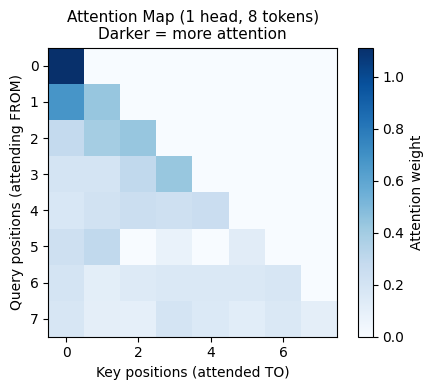

   Each row = probability distribution over previous tokens ✓


In [ ]:
# ══════════════════════════════════════════════════════════════
# PART 3 — Single Attention Head (fully from scratch)
# ══════════════════════════════════════════════════════════════

class Head(nn.Module):
    """
    One head of causal self-attention.

    Each token projects itself into Q, K, V spaces.
    Scores = Q·Kᵀ / sqrt(head_size)  → softmax → weighted sum of V.
    Causal mask ensures token i only sees tokens 0..i (no future peeking).
    """
    def __init__(self, head_size):
        super().__init__()
        self.key   = nn.Linear(n_embd, head_size, bias=False)  # W_K
        self.query = nn.Linear(n_embd, head_size, bias=False)  # W_Q
        self.value = nn.Linear(n_embd, head_size, bias=False)  # W_V
        self.dropout = nn.Dropout(dropout)

        # Lower-triangular mask (causal / autoregressive mask)
        # register_buffer = not a parameter, but saved with model
        self.register_buffer('tril', torch.tril(torch.ones(block_size, block_size)))

    def forward(self, x):
        B, T, C = x.shape           # (Batch, Time/Tokens, Channels)

        k = self.key(x)             # (B, T, head_size)
        q = self.query(x)           # (B, T, head_size)
        v = self.value(x)           # (B, T, head_size)

        # ── Attention scores ──────────────────────────────────
        head_size = k.shape[-1]
        # Scale by √d to prevent dot products from growing too large
        wei = q @ k.transpose(-2, -1) * head_size**-0.5   # (B, T, T)

        # ── Causal mask: future positions → -inf → softmax → 0 ──
        wei = wei.masked_fill(self.tril[:T, :T] == 0, float('-inf'))

        # ── Softmax → probability distribution over positions ──
        wei = F.softmax(wei, dim=-1)  # (B, T, T)
        wei = self.dropout(wei)

        # ── Weighted aggregation of Values ────────────────────
        out = wei @ v                  # (B, T, head_size)
        return out, wei                # return weights for visualization

# ── Quick test ────────────────────────────────────────────────
test_head = Head(head_size=32).to(device)
test_x    = torch.randn(2, 8, n_embd).to(device)   # (B=2, T=8, C=128)
out, attn_weights = test_head(test_x)

print("✅ Single attention head works!")
print(f"   Input  shape: {test_x.shape}   (B, T, n_embd)")
print(f"   Output shape: {out.shape}    (B, T, head_size)")
print(f"   Attn weights: {attn_weights.shape}     (B, T, T) — attention map")

# Visualize one attention map
plt.figure(figsize=(5,4))
plt.imshow(attn_weights[0].detach().cpu().numpy(), cmap='Blues')
plt.title("Attention Map (1 head, 8 tokens)\nDarker = more attention", fontsize=11)
plt.xlabel("Key positions (attended TO)")
plt.ylabel("Query positions (attending FROM)")
plt.colorbar(label="Attention weight")
plt.tight_layout(); plt.show()
print("   Each row = probability distribution over previous tokens ✓")

---
# 🔀 PART 4 — Multi-Head Attention
### *"Run multiple attention heads in parallel — each learns different relationships"*

**Theory (from slides):**
- One head might focus on **subject-verb agreement**
- Another on **coreference** ("he" → who?)
- Another on **negation scope** ("not" → what?)
- Concatenate all head outputs → project back to n_embd
```
MultiHead(Q,K,V) = Concat(head₁, head₂, ..., headₙ) · W_O
```



 Multi-Head Attention (Code)

✅ MultiHeadAttention works!
   Input  : torch.Size([2, 8, 128])   (B, T, n_embd=128)
   Output : torch.Size([2, 8, 128])   (B, T, n_embd=128)
   Heads  : 4 attention maps, each torch.Size([2, 8, 8])



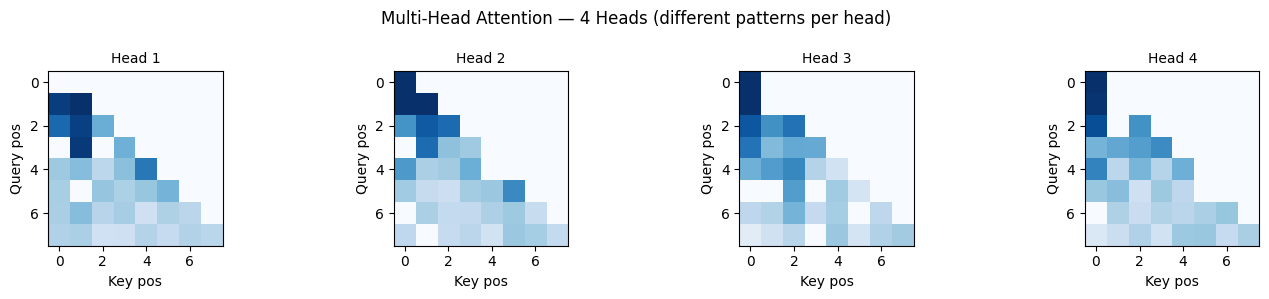

Each head attends to DIFFERENT parts of the context — that's the power of multi-head!


In [ ]:
# ══════════════════════════════════════════════════════════════
# PART 4 — Multi-Head Attention
# ══════════════════════════════════════════════════════════════

class MultiHeadAttention(nn.Module):
    """
    Multiple attention heads running IN PARALLEL.
    Each head gets head_size = n_embd // n_head dimensions.
    Outputs are concatenated → projected back to n_embd.

    This is what was missing from your original notebook!
    """
    def __init__(self, num_heads, head_size):
        super().__init__()
        self.heads   = nn.ModuleList([Head(head_size) for _ in range(num_heads)])
        self.proj    = nn.Linear(num_heads * head_size, n_embd)  # W_O projection
        self.dropout = nn.Dropout(dropout)

    def forward(self, x):
        # Run all heads in parallel, collect outputs AND attention weights
        head_outputs = [h(x) for h in self.heads]
        out_parts    = [o for o, _ in head_outputs]
        attn_maps    = [w for _, w in head_outputs]

        # Concatenate along the last (channel) dimension
        out = torch.cat(out_parts, dim=-1)   # (B, T, num_heads * head_size)
        out = self.dropout(self.proj(out))   # (B, T, n_embd)
        return out, attn_maps

# ── Test ──────────────────────────────────────────────────────
head_size = n_embd // n_head   # 128 // 4 = 32
mha       = MultiHeadAttention(num_heads=n_head, head_size=head_size).to(device)
test_x    = torch.randn(2, 8, n_embd).to(device)
out, attn_maps = mha(test_x)

print("✅ MultiHeadAttention works!")
print(f"   Input  : {test_x.shape}   (B, T, n_embd={n_embd})")
print(f"   Output : {out.shape}   (B, T, n_embd={n_embd})")
print(f"   Heads  : {len(attn_maps)} attention maps, each {attn_maps[0].shape}")
print()

# Visualize all 4 heads side by side
fig, axes = plt.subplots(1, n_head, figsize=(14, 3))
fig.suptitle(f"Multi-Head Attention — {n_head} Heads (different patterns per head)", fontsize=12)
for i, (ax, amap) in enumerate(zip(axes, attn_maps)):
    im = ax.imshow(amap[0].detach().cpu().numpy(), cmap='Blues', vmin=0, vmax=0.5)
    ax.set_title(f"Head {i+1}", fontsize=10)
    ax.set_xlabel("Key pos"); ax.set_ylabel("Query pos")
plt.tight_layout(); plt.show()
print("Each head attends to DIFFERENT parts of the context — that's the power of multi-head!")

---
# 🧱 PART 5 — Transformer Block (Add & Norm + Feed-Forward)
### *"The repeating unit stacked N times to build GPT"*

**Theory (from slides — Inside a Transformer Block):**
```
Input → Self-Attention → Add & Norm → Feed-Forward → Add & Norm → Output
         (communication)    ↑            (computation)     ↑
                      residual +                      residual +
                      LayerNorm                       LayerNorm
```

**Residual connections** (x + sublayer(x)) solve vanishing gradients  
**LayerNorm** stabilizes training by normalizing activations  
**Feed-Forward** (4× wider hidden layer) applies nonlinear transformation

 FeedForward & Block (Code)

In [ ]:
# ══════════════════════════════════════════════════════════════
# PART 5A — Feed-Forward Network
# ══════════════════════════════════════════════════════════════

class FeedForward(nn.Module):
    """
    Position-wise feed-forward network.
    Applied independently to each token (no interaction between tokens here).
    Hidden layer is 4× wider — GPT-style.

    Architecture: Linear(n_embd → 4*n_embd) → ReLU → Linear(4*n_embd → n_embd)
    """
    def __init__(self, n_embd):
        super().__init__()
        self.net = nn.Sequential(
            nn.Linear(n_embd, 4 * n_embd),
            nn.ReLU(),
            nn.Linear(4 * n_embd, n_embd),
            nn.Dropout(dropout),
        )

    def forward(self, x):
        return self.net(x)


# ══════════════════════════════════════════════════════════════
# PART 5B — Full Transformer Block
# ══════════════════════════════════════════════════════════════

class Block(nn.Module):
    """
    One complete Transformer block:
      1. LayerNorm → Multi-Head Attention → Residual Add
      2. LayerNorm → Feed-Forward         → Residual Add

    Note: We use Pre-LN (norm before sublayer) — more stable than original paper.
    """
    def __init__(self, n_embd, n_head):
        super().__init__()
        head_size = n_embd // n_head
        self.sa   = MultiHeadAttention(n_head, head_size)  # Communication
        self.ffwd = FeedForward(n_embd)                    # Computation
        self.ln1  = nn.LayerNorm(n_embd)                   # Norm before attention
        self.ln2  = nn.LayerNorm(n_embd)                   # Norm before FFN

    def forward(self, x):
        # ── Communication with residual connection ────────────
        attn_out, attn_maps = self.sa(self.ln1(x))
        x = x + attn_out              # Residual: preserve original info

        # ── Computation with residual connection ──────────────
        x = x + self.ffwd(self.ln2(x))
        return x, attn_maps

# ── Test ──────────────────────────────────────────────────────
block  = Block(n_embd, n_head).to(device)
test_x = torch.randn(2, block_size, n_embd).to(device)
out, _ = block(test_x)

print("✅ Transformer Block works!")
print(f"   Input  : {test_x.shape}")
print(f"   Output : {out.shape}  (same shape — residual connections!)")
print()

# Count parameters in one block
block_params = sum(p.numel() for p in block.parameters())
print(f"   Parameters in ONE block: {block_params:,}")
print(f"   Parameters in {n_layer} blocks:   {block_params * n_layer:,}")

✅ Transformer Block works!
   Input  : torch.Size([2, 64, 128])
   Output : torch.Size([2, 64, 128])  (same shape — residual connections!)

   Parameters in ONE block: 197,888
   Parameters in 3 blocks:   593,664


---
# 🤖 PART 6 — Full GPT Model: Assembly
### *"A Token's Journey — from raw characters to predicted probabilities"*

**Architecture (from slides):**
```
Input chars
    ↓
[Token Embedding] + [Positional Embedding]   ← "where am I?" signal
    ↓
[Transformer Block 1]  ─── Multi-Head Attn + FFN
[Transformer Block 2]  ─── Multi-Head Attn + FFN  
[Transformer Block 3]  ─── Multi-Head Attn + FFN
    ↓
[LayerNorm]
    ↓
[Linear head] → logits (vocab_size)
    ↓
[Softmax] → next-token probabilities
```

Full GPT Model (Code)

In [ ]:
# ══════════════════════════════════════════════════════════════
# PART 6 — Complete GPT Language Model
# ══════════════════════════════════════════════════════════════

class GPTModel(nn.Module):
    """
    Decoder-only Transformer (GPT-style).

    Components:
      • Token Embedding    : maps each character ID → learned vector
      • Position Embedding : maps each position    → learned vector
      • N Transformer Blocks stacked
      • Final LayerNorm + Linear head → vocabulary logits
    """

    def __init__(self):
        super().__init__()

        # ── Embeddings ────────────────────────────────────────
        self.token_embedding_table    = nn.Embedding(vocab_size, n_embd)
        self.position_embedding_table = nn.Embedding(block_size, n_embd)

        # ── Stacked Transformer Blocks ────────────────────────
        self.blocks = nn.ModuleList([Block(n_embd, n_head) for _ in range(n_layer)])

        # ── Output Head ───────────────────────────────────────
        self.ln_f    = nn.LayerNorm(n_embd)            # final norm
        self.lm_head = nn.Linear(n_embd, vocab_size)   # project → vocab logits

        # ── Weight initialization (important for training stability) ──
        self.apply(self._init_weights)

    def _init_weights(self, module):
        if isinstance(module, nn.Linear):
            torch.nn.init.normal_(module.weight, mean=0.0, std=0.02)
            if module.bias is not None:
                torch.nn.init.zeros_(module.bias)
        elif isinstance(module, nn.Embedding):
            torch.nn.init.normal_(module.weight, mean=0.0, std=0.02)

    def forward(self, idx, targets=None):
        B, T = idx.shape

        # ── Step 1: Token + Positional Embeddings ─────────────
        tok_emb = self.token_embedding_table(idx)                              # (B, T, n_embd)
        pos_emb = self.position_embedding_table(torch.arange(T, device=device)) # (T, n_embd)
        x = tok_emb + pos_emb    # Semantic meaning + position signal

        # ── Step 2: Pass through all Transformer Blocks ───────
        all_attn = []
        for block in self.blocks:
            x, attn = block(x)
            all_attn.append(attn)

        # ── Step 3: Final LayerNorm ────────────────────────────
        x = self.ln_f(x)

        # ── Step 4: Project to vocabulary ─────────────────────
        logits = self.lm_head(x)    # (B, T, vocab_size)

        # ── Step 5: Compute loss (if training) ────────────────
        loss = None
        if targets is not None:
            B, T, C = logits.shape
            logits  = logits.view(B * T, C)
            targets = targets.view(B * T)
            loss    = F.cross_entropy(logits, targets)

        return logits, loss, all_attn

    @torch.no_grad()
    def generate(self, idx, max_new_tokens, temperature=1.0, top_k=None):
        """
        Autoregressively generate new tokens.
        temperature > 1 → more random | temperature < 1 → more focused
        top_k → only sample from top-k most likely tokens
        """
        for _ in range(max_new_tokens):
            # Crop to context window
            idx_cond = idx[:, -block_size:]

            # Forward pass
            logits, _, _ = self(idx_cond)
            logits = logits[:, -1, :] / temperature   # (B, vocab_size)

            # Optional: top-k sampling
            if top_k is not None:
                v, _ = torch.topk(logits, min(top_k, logits.size(-1)))
                logits[logits < v[:, [-1]]] = float('-inf')

            probs    = F.softmax(logits, dim=-1)
            idx_next = torch.multinomial(probs, num_samples=1)
            idx      = torch.cat((idx, idx_next), dim=1)
        return idx


# ── Instantiate & inspect ──────────────────────────────────────
model = GPTModel().to(device)
total_params = sum(p.numel() for p in model.parameters())

print("✅ GPT Model created successfully!")
print(f"\n📐 Architecture Summary:")
print(f"   vocab_size  : {vocab_size}")
print(f"   n_embd      : {n_embd}")
print(f"   n_head      : {n_head}")
print(f"   n_layer     : {n_layer}")
print(f"   block_size  : {block_size}")
print(f"\n🔢 Total Parameters: {total_params:,}  ({total_params/1e6:.2f}M)")
print(f"\n   (GPT-2 small = 117M params | GPT-3 = 175B params)")

# Quick forward pass test
xb, yb = get_batch('train')
logits, loss, _ = model(xb, yb)
print(f"\n🔍 Untrained model:")
print(f"   Loss   = {loss.item():.4f}  (should be ≈ {math.log(vocab_size):.4f} = ln({vocab_size}))")
print(f"   Logits = {logits.shape}  (B × T × vocab_size)")

✅ GPT Model created successfully!

📐 Architecture Summary:
   vocab_size  : 65
   n_embd      : 128
   n_head      : 4
   n_layer     : 3
   block_size  : 64

🔢 Total Parameters: 618,817  (0.62M)

   (GPT-2 small = 117M params | GPT-3 = 175B params)

🔍 Untrained model:
   Loss   = 4.2481  (should be ≈ 4.1744 = ln(65))
   Logits = torch.Size([2048, 65])  (B × T × vocab_size)


---
# 🏋️ PART 7 — Training Loop + Text Generation
### *"Pre-training: self-supervised next-token prediction"*

**Theory (from slides):**
- **Pre-training** = learn to predict the next token on massive unlabeled data
- Loss = Cross-Entropy between predicted probabilities and actual next token
- Optimizer = AdamW (Adam with weight decay)
- At each step: forward → compute loss → backprop → update weights

**Expected loss curve:**
- Start: ~4.17 (random, ln(65))
- After 3000 steps: ~1.6–1.8 (meaningful patterns learned!)

Training Loop (Code)

🚀 Starting training...

  Step | Train Loss |   Val Loss
-----------------------------------
     0 |     4.2480 |     4.2487
   500 |     1.9141 |     1.9376
  1000 |     1.7333 |     1.8203
  1500 |     1.6236 |     1.8227
  2000 |     1.5383 |     1.7390
  2500 |     1.4792 |     1.7528
  3000 |     1.5110 |     1.7668

✅ Training complete!


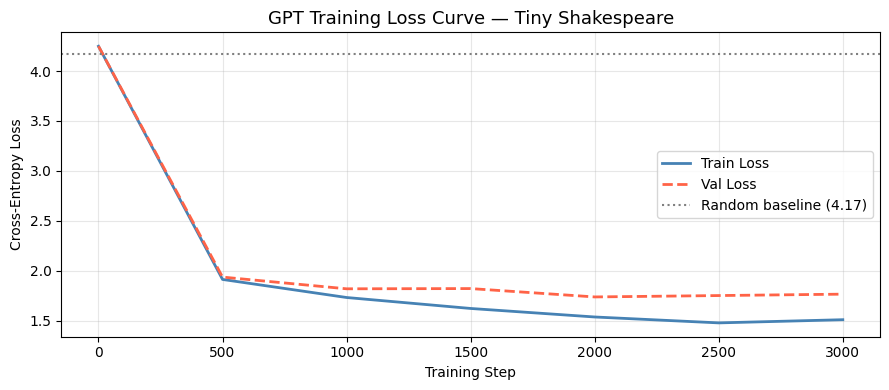

In [ ]:
# ══════════════════════════════════════════════════════════════
# PART 7 — Training Loop
# ══════════════════════════════════════════════════════════════

optimizer = torch.optim.AdamW(model.parameters(), lr=learning_rate)

train_losses = []
val_losses   = []
iters_log    = []

print("🚀 Starting training...\n")
print(f"{'Step':>6} | {'Train Loss':>10} | {'Val Loss':>10}")
print("-" * 35)

for step in range(max_iters + 1):

    # ── Evaluate periodically ──────────────────────────────
    if step % eval_interval == 0:
        model.eval()
        with torch.no_grad():
            xb_t, yb_t = get_batch('train')
            xb_v, yb_v = get_batch('val')
            _, t_loss, _ = model(xb_t, yb_t)
            _, v_loss, _ = model(xb_v, yb_v)
        t_loss_val = t_loss.item()
        v_loss_val = v_loss.item()
        train_losses.append(t_loss_val)
        val_losses.append(v_loss_val)
        iters_log.append(step)
        print(f"{step:>6} | {t_loss_val:>10.4f} | {v_loss_val:>10.4f}")
        model.train()

    if step == max_iters:
        break

    # ── Training step ──────────────────────────────────────
    xb, yb          = get_batch('train')
    logits, loss, _ = model(xb, yb)
    optimizer.zero_grad(set_to_none=True)
    loss.backward()
    optimizer.step()

print("\n✅ Training complete!")

# ── Plot loss curves ──────────────────────────────────────────
plt.figure(figsize=(9, 4))
plt.plot(iters_log, train_losses, label='Train Loss', color='steelblue', linewidth=2)
plt.plot(iters_log, val_losses,   label='Val Loss',   color='tomato',    linewidth=2, linestyle='--')
plt.axhline(y=math.log(vocab_size), color='gray', linestyle=':', label=f'Random baseline ({math.log(vocab_size):.2f})')
plt.xlabel("Training Step"); plt.ylabel("Cross-Entropy Loss")
plt.title("GPT Training Loss Curve — Tiny Shakespeare", fontsize=13)
plt.legend(); plt.grid(alpha=0.3); plt.tight_layout(); plt.show()

Generate Text (Code)

In [ ]:
# ══════════════════════════════════════════════════════════════
# PART 7B — Generate Shakespeare with Trained GPT!
# ══════════════════════════════════════════════════════════════

model.eval()

def generate_text(prompt="", max_new_tokens=500, temperature=0.8, top_k=40):
    """Generate text from the trained model."""
    if prompt:
        context = torch.tensor([encode(prompt)], dtype=torch.long, device=device)
    else:
        # Start from newline
        context = torch.zeros((1, 1), dtype=torch.long, device=device)

    with torch.no_grad():
        generated_ids = model.generate(context, max_new_tokens=max_new_tokens,
                                        temperature=temperature, top_k=top_k)
    return decode(generated_ids[0].tolist())

print("=" * 65)
print("🎭 GENERATED SHAKESPEARE  (temperature=0.8, top_k=40):")
print("=" * 65)
print(generate_text(prompt="\n", max_new_tokens=600, temperature=0.8, top_k=40))

print("\n" + "=" * 65)
print("🎭 MORE FOCUSED output  (temperature=0.5):")
print("=" * 65)
print(generate_text(prompt="\n", max_new_tokens=300, temperature=0.5, top_k=20))

🎭 GENERATED SHAKESPEARE  (temperature=0.8, top_k=40):

purpon and a batter affer no boe.

CORIOLANUS:
There of my quit, they is is the soul.

First Citizen:
There this thanks to the is thy traitor,
Than humble all Burn swear our other, and by a banish son
To dith his done for mine; ever a more body in reason.

KING HENRY VI:
Looks thee to accoptition mine chance: and shepherd that fortune
The duke in this blood some own it was come:
What is befair doth const and vantiance.

JULIET:
Upon him in the dear that thou mayst hast her;
Wert no boy; if you behing that you then discontry no help.

SICINIUS:
The world should Romeo:
Thou hast the been that to

🎭 MORE FOCUSED output  (temperature=0.5):

The will be with the tongue of York's mine.

QUEEN ELIZABETH:
What we will the thoughts for mistand which earth.

CORIOLANUS:
There an the thank that hath a strengthen some senger,
Which would the bear of are the stranger of him ears.

First We thou art with the housand of his father's strumpet.

AU

In [ ]:
r

In [ ]:
# Prompt based Text Generation

print("=" * 65)
print("🚀 INTERACTIVE GPT MODE")
print("=" * 65)
print("Type 'exit' to stop. Your model will try to continue your text in Shakespearean style!")

while True:
    user_input = input("\nEnter your prompt: ")

    if user_input.lower() == 'exit':
        break

    # Handle empty input by defaulting to a newline
    prompt_str = user_input if user_input.strip() != "" else "\n"

    print("\n--- Generating... ---")
    output = generate_text(
        prompt=prompt_str,
        max_new_tokens=200,
        temperature=0.7,
        top_k=40
    )
    print(output)
    print("-" * 30)

🚀 INTERACTIVE GPT MODE
Type 'exit' to stop. Your model will try to continue your text in Shakespearean style!

Enter your prompt: what is ai

--- Generating... ---
what is air scare on my love,
Or father than do in will be that him;
that yet your fathers is me an our disgreath:
Door you cannot thy father to procial thank you will his
by to Glace a purping fair,
And thy fa
------------------------------

Enter your prompt: who is queen 

--- Generating... ---
who is queen no thought on my man,
In dispres heart, the scries, who all sir.

QUEEN ELIZABETH:
As your voicestering in all my crown; then thank no three
To may as a will be dearth his sour death, this
that is in 
------------------------------

Enter your prompt: exit


 Temperature Sampling Demo (Code)

In [ ]:
# ══════════════════════════════════════════════════════════════
# PART 7C — How Temperature Controls Creativity
# ══════════════════════════════════════════════════════════════

temps = [0.3, 0.8, 1.5]
labels = ["🧊 Low (0.3) — focused/repetitive",
          "⚖️  Mid (0.8) — balanced (recommended)",
          "🔥 High (1.5) — creative/chaotic"]

for temp, label in zip(temps, labels):
    print(f"\n{'─'*60}")
    print(f"Temperature = {label}")
    print('─'*60)
    print(generate_text(prompt="\n", max_new_tokens=150, temperature=temp, top_k=40))

print("\n💡 Lower temperature → model is more 'confident' (picks top tokens)")
print("   Higher temperature → model is more 'adventurous' (broader sampling)")


────────────────────────────────────────────────────────────
Temperature = 🧊 Low (0.3) — focused/repetitive
────────────────────────────────────────────────────────────

The sun stand that with him the soul straight the should of the son
The sentender of the stand of the seast of the death.

BENVOLIO:
What is hear the 

────────────────────────────────────────────────────────────
Temperature = ⚖️  Mid (0.8) — balanced (recommended)
────────────────────────────────────────────────────────────

My father's no father farewels? appetual see!
Thou hast would with then he with wilt thy geling.

BRUTUS:
Hath half their break, our commonger, now ou

────────────────────────────────────────────────────────────
Temperature = 🔥 High (1.5) — creative/chaotic
────────────────────────────────────────────────────────────

Duke unwilt by hinkingnory giving, curcy mequil 'strad Lultainst.

WARWICK:
Aholvil! ships gould! wasteliges by lixt; my lie. Help? withorough friend'

💡 Lower temperature → model 

 Final Summary :
 ---
# 🎓 What We Built

## ✅ Full Journey: N-grams → GPT
```
PART 1  N-gram Models      → Statistical word prediction (counts)
PART 2  Tokenization       → Text → Token IDs → Embeddings
PART 3  Single Attention   → Q·Kᵀ/√d · V with causal mask
PART 4  Multi-Head Attn    → n_head parallel attention streams  ← fixed your bug!
PART 5  Transformer Block  → Attention + FFN + Residuals + LayerNorm
PART 6  GPT Assembly       → Token emb + Pos emb + N blocks + LM head
PART 7  Training           → Self-supervised next-token prediction

```

## 🔑 Key Insights

| Concept | Why It Matters |
|---------|---------------|
| **Residual connections** | Gradients flow directly → deep networks train |
| **LayerNorm** | Stable activations → faster convergence |
| **Positional embeddings** | Transformers are order-agnostic without this |
| **Causal masking** | Prevents the model from "seeing the future" |
| **Temperature** | Controls the creativity vs. coherence tradeoff |
| **Multi-head attention** | Each head specializes in different linguistic patterns |

## 🚀 What's Next?

- **Scale up:** More layers, larger embeddings → better quality
- **Fine-tuning:** Instruct-tune the base model → ChatGPT-style assistant
- **RLHF:** Align with human preferences (SFT → Reward Model → PPO)
- **Efficiency:** Flash Attention, LoRA, quantization

---
*Built at the ACM LLM Workshop — From N-grams to GPT 🎭*